# Stage 1: Imports

In [1]:
import os
import random
import re
from collections import Counter, defaultdict
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from PIL import Image
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm

# Stage 2: Configuration & Global Variables

## Seeds

setting random seeds, for better reproducibility

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # Potentially add for full determinism (can slow down training)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

## Device

setting up device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"Device name: {torch.cuda.get_device_name(0)}")

Using device: cuda
Device name: NVIDIA GeForce RTX 4080 SUPER


## File Paths

In [4]:
IMAGE_ROOT_DIR = "flickr8k/Images"
CAPTIONS_CSV_FILE = "flickr8k/captions.txt"
MODEL_SAVE_PATH = "best_image_captioning_model.pth"

## Hyperparameters

In [5]:
# Hyperparameters
BATCH_SIZE = 32 # Adjusted from 16 for potentially faster training
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS_LSTM = 1 # Explicitly named
LEARNING_RATE = 3e-4
NUM_EPOCHS = 10 # Adjusted from 8
FREQ_THRESHOLD_VOCAB = 5 # Min frequency for a word to be in vocab
VALIDATION_SPLIT_SIZE = 0.2 # 20% for validation

In [6]:
# Beam Search Parameters
BEAM_WIDTH = 3
MAX_CAPTION_LENGTH = 50

# Stage 3: Helper Functions

In [7]:
def unnormalize_image(img_tensor: torch.Tensor) -> np.ndarray:
    """
    Reverses the ImageNet normalization on an image tensor for display.

    Args:
        img_tensor: A PyTorch tensor representing the normalized image.

    Returns:
        A NumPy array representing the unnormalized image, suitable for plt.imshow.
    """
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    img = img_tensor * std + mean
    img = img.clamp(0, 1).cpu().detach().permute(1, 2, 0).numpy()
    return img

# Stage 4: Vocabulary Class

In [8]:
class Vocabulary:
    """
    Manages the mapping between words and numerical indices for image captions.
    """
    def __init__(self, freq_threshold: int):
        """
        Args:
            freq_threshold: The minimum frequency for a word to be included in the vocabulary.
        """
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {word: idx for idx, word in self.itos.items()}
        self.idx = len(self.itos) # Start indexing after special tokens

    def __len__(self) -> int:
        return len(self.itos)

    def add_word(self, word: str):
        """Adds a word to the vocabulary if it's not already present."""
        if word not in self.stoi:
            self.stoi[word] = self.idx
            self.itos[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, sentence_list: list[str]):
        """
        Builds the vocabulary from a list of sentences.

        Args:
            sentence_list: A list of caption strings.
        """
        frequencies = Counter()
        for sentence in sentence_list:
            for word in re.findall(r'\b\w+\b', sentence.lower()):
                frequencies[word] += 1

        for word, count in frequencies.items():
            if count >= self.freq_threshold:
                self.add_word(word)

    def numericalize(self, text: str) -> list[int]:
        """
        Converts a text string into a list of numerical indices.

        Args:
            text: The caption string.

        Returns:
            A list of numerical indices representing the caption.
        """
        tokenized_text = re.findall(r'\b\w+\b', text.lower())
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text]

# Stage 5: Dataset and DataLoader

## Dataset

In [9]:
class Flickr8kDataset(Dataset):
    """
    PyTorch Dataset for loading Flickr8k images and captions.
    """
    def __init__(self, root_dir: str, captions_df: pd.DataFrame, vocab: Vocabulary, transform=None):
        """
        Args:
            root_dir: Directory with all the images.
            captions_df: Pandas DataFrame with 'image' and 'caption' columns.
            vocab: An instance of the Vocabulary class.
            transform: Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.df = captions_df
        self.vocab = vocab
        self.transform = transform

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        row = self.df.iloc[index]
        img_id = row["image"]
        caption_text = row["caption"]
        img_path = os.path.join(self.root_dir, img_id)

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
        except FileNotFoundError:
            print(f"Error: Image file not found at {img_path}")
            # Return a dummy image and caption or raise error
            # For simplicity, let's assume files are always present or handle upstream
            raise

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption.extend(self.vocab.numericalize(caption_text))
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return image, torch.tensor(numericalized_caption)

## Image Transformations (Enhancement)

In [10]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize to a bit larger than crop size
    transforms.RandomCrop((224, 224)), # Random crop for data augmentation during training
    transforms.RandomHorizontalFlip(), # Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
# Simpler transform for validation/testing (no random augmentation)
val_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Collate

Collate function for padding caption sequences in a batch

In [12]:
class CollateFn:
    """
    Custom collate_fn for DataLoader to handle padding of caption sequences.
    """
    def __init__(self, pad_idx: int):
        self.pad_idx = pad_idx

    def __call__(self, batch: list[tuple[torch.Tensor, torch.Tensor]]) -> tuple[torch.Tensor, torch.Tensor]:
        images = [item[0].unsqueeze(0) for item in batch]
        images = torch.cat(images, dim=0)

        captions = [item[1] for item in batch]
        captions = pad_sequence(captions, batch_first=False, padding_value=self.pad_idx)
        return images, captions

# Stage 6: Model Architecture

## Encoder CNN (ResNet50)

In [13]:
class EncoderCNN(nn.Module):
    """
    CNN Encoder (ResNet50 based) to extract image features.
    """
    def __init__(self, embed_size: int, train_cnn: bool = False):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1) # Use updated API for pretrained weights

        # Freeze or allow training of ResNet layers
        for param in resnet.parameters():
            param.requires_grad = train_cnn

        modules = list(resnet.children())[:-1]  # Remove the final FC layer
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        # self.dropout = nn.Dropout(0.5) # Optional dropout

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        # No torch.no_grad() here if train_cnn is True and we want to fine-tune
        features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        # features = self.dropout(features) # Optional
        return features

## Decoder RNN (Basic LSTM)

In [14]:
class DecoderRNN(nn.Module):
    """
    LSTM Decoder to generate captions from image features.
    """
    def __init__(self, embed_size: int, hidden_size: int, vocab_size: int, num_layers: int, dropout_prob: float = 0.5):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout_prob if num_layers > 1 else 0)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout_prob) # Apply dropout before final linear layer

    def forward(self, features: torch.Tensor, captions: torch.Tensor) -> torch.Tensor:
        # features shape: (batch_size, embed_size)
        # captions shape: (seq_len, batch_size) during training
        embeddings = self.dropout(self.embed(captions)) # (seq_len, batch_size, embed_size)

        # Concatenate image features with caption embeddings
        # features.unsqueeze(0) shape: (1, batch_size, embed_size)
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0) # (1 + seq_len, batch_size, embed_size)

        hiddens, _ = self.lstm(embeddings) # hiddens shape: (1 + seq_len, batch_size, hidden_size)
        outputs = self.linear(hiddens) # outputs shape: (1 + seq_len, batch_size, vocab_size)
        return outputs

# Stage 7: Caption Generation Function (beam search)

In [15]:
def generate_caption_beam_search(
    image_tensor: torch.Tensor,
    encoder: EncoderCNN,
    decoder: DecoderRNN,
    vocab: Vocabulary,
    device: torch.device,
    max_len: int = MAX_CAPTION_LENGTH,
    beam_width: int = BEAM_WIDTH,
    length_penalty_alpha: float = 0.7 # For Google's NMT length penalty (lp)
) -> list[str]:
    """
    Generates a caption for an image using beam search.

    Args:
        image_tensor: Preprocessed image tensor (3, H, W).
        encoder: Trained EncoderCNN model.
        decoder: Trained DecoderRNN model.
        vocab: Vocabulary object.
        device: PyTorch device.
        max_len: Maximum length for the generated caption.
        beam_width: Number of beams to keep.
        length_penalty_alpha: Alpha parameter for length penalty.

    Returns:
        A list of strings representing the generated caption tokens.
    """
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        encoder_output = encoder(image_tensor.unsqueeze(0).to(device)) # (1, embed_size)

        # Process image feature through LSTM to get initial states
        initial_features_for_lstm = encoder_output.unsqueeze(0) # (1, 1, embed_size)
        _, current_lstm_states = decoder.lstm(initial_features_for_lstm, None) # ( (num_layers, 1, hidden_size), ... )

        sos_idx = vocab.stoi["<SOS>"]
        eos_idx = vocab.stoi["<EOS>"]

        # sequences: [ ([word_indices], cumulative_log_score, lstm_states) ]
        sequences = [[[sos_idx], 0.0, current_lstm_states]]
        completed_sequences = []

        for _ in range(max_len):
            all_candidates = []
            for seq_indices, score, prev_lstm_states in sequences:
                if seq_indices[-1] == eos_idx:
                    # Apply length penalty for completed sequences
                    # lp = ((5 + len(seq_indices)) / (5 + 1)) ** length_penalty_alpha
                    # penalized_score = score / lp
                    # completed_sequences.append((seq_indices, penalized_score))
                    completed_sequences.append((seq_indices, score)) # Store raw score for now, penalize at the very end
                    continue

                last_word_idx = seq_indices[-1]
                word_input_tensor = torch.tensor([last_word_idx], device=device)
                embedding_for_lstm = decoder.embed(word_input_tensor).unsqueeze(0) # (1, 1, embed_size)

                hiddens_from_lstm, new_lstm_states = decoder.lstm(embedding_for_lstm, prev_lstm_states)
                output_logits = decoder.linear(hiddens_from_lstm.squeeze(0)) # (1, vocab_size)
                log_probs = torch.log_softmax(output_logits, dim=1)

                topk_log_probs, topk_indices = log_probs.topk(beam_width, dim=1)

                for i in range(beam_width):
                    next_word_idx = topk_indices[0][i].item()
                    next_word_log_prob = topk_log_probs[0][i].item()

                    new_candidate_seq = seq_indices + [next_word_idx]
                    new_candidate_score = score + next_word_log_prob
                    all_candidates.append((new_candidate_seq, new_candidate_score, new_lstm_states))

            if not all_candidates: break

            # Prune candidates: keep top 'beam_width' based on score
            ordered_candidates = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences = ordered_candidates[:beam_width]

            # Stop if all current beams ended with <EOS> and added to completed_sequences
            if all(s[0][-1] == eos_idx for s in sequences) and len(completed_sequences) >= beam_width :
                 break # Optimization: if all active beams are now completed.

        # Add remaining active sequences to completed (if they didn't end with EOS)
        for seq, score, _ in sequences:
            is_completed = any(seq == c_seq[0] for c_seq in completed_sequences)
            if not is_completed: # Avoid duplicates
                 completed_sequences.append((seq, score))


        if not completed_sequences:
            # Fallback: if no completed sequence (e.g. all stuck or too short),
            # take the best active one. This is rare with proper EOS handling.
            if sequences:
                 best_sequence_data = sequences[0] # (seq_indices, score, states)
                 best_sequence_indices = best_sequence_data[0]
            else:
                 return ["<UNK>"] # Should not happen
        else:
            # Sort completed sequences. Apply length penalty here for final ranking.
            def get_penalized_score(seq_data):
                seq, log_prob = seq_data
                lp = ((5 + len(seq)) / 6.0) ** length_penalty_alpha # GNMT length penalty factor
                return log_prob / lp

            completed_sequences.sort(key=get_penalized_score, reverse=True)
            best_sequence_indices = completed_sequences[0][0]

        return [
            vocab.itos[idx] for idx in best_sequence_indices
            if idx not in {vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]}
        ]

# Stage 8: Evaluation Function

In [31]:
def evaluate_model(
    encoder: EncoderCNN,
    decoder: DecoderRNN,
    loader: DataLoader, # This loader's dataset is an instance of Flickr8kDataset
    criterion: nn.CrossEntropyLoss,
    vocab: Vocabulary,
    device: torch.device,
    image_id_to_references: dict
) -> tuple[float, float]:
    encoder.eval()
    decoder.eval()

    total_loss = 0.0
    total_bleu4_score = 0.0
    num_evaluated_samples = 0

    # loader.dataset is now the actual Flickr8kDataset instance (e.g., val_dataset)
    # It contains its own .df which is already filtered for the validation split.
    current_eval_dataset = loader.dataset
    smoothing_fn = SmoothingFunction().method4

    with torch.no_grad():
        for batch_idx, (imgs, captions_true_padded) in enumerate(tqdm(loader, desc="Validating", leave=False)):
            imgs = imgs.to(device)
            captions_true_padded = captions_true_padded.to(device)

            captions_input = captions_true_padded[:-1, :]
            captions_target = captions_true_padded[1:, :]

            features = encoder(imgs)
            outputs = decoder(features, captions_input)

            # Corrected loss calculation from previous fix
            batch_loss = criterion(
                outputs[:-1, :, :].reshape(-1, outputs.shape[2]),
                captions_target.reshape(-1)
            )
            total_loss += batch_loss.item() * imgs.size(0)

            for i in range(imgs.size(0)): # Iterate through items in the current batch
                img_tensor_single = imgs[i]

                # Get original image ID for BLEU reference lookup
                # Since val_loader.shuffle is False, items are processed in order.
                # The index into current_eval_dataset.df is:
                item_index_in_current_dataset = batch_idx * loader.batch_size + i

                if item_index_in_current_dataset < len(current_eval_dataset): # Boundary check
                    # Access the df of the current_eval_dataset (e.g., val_dataset.df)
                    img_id_str = current_eval_dataset.df.iloc[item_index_in_current_dataset]["image"]

                    references_str_list = image_id_to_references.get(img_id_str)
                    if references_str_list:
                        tokenized_references = [[word.lower() for word in ref.split()] for ref in references_str_list]

                        generated_caption_tokens = generate_caption_beam_search(
                            img_tensor_single, encoder, decoder, vocab, device
                        ) # Beam search parameters will use defaults defined in the function

                        total_bleu4_score += sentence_bleu(
                            tokenized_references,
                            generated_caption_tokens,
                            #weights=(1, 0, 0, 0), # BLEU-1
                            #weights=(0.5, 0.5, 0, 0), # BLEU-2
                            #weights=(0.333, 0.333, 0.333, 0), # BLEU-3
                            weights=(0.25, 0.25, 0.25, 0.25), # BLEU-4
                            smoothing_function=smoothing_fn
                        )
                        num_evaluated_samples += 1
                    # else:
                        # This might happen if an image ID from val_dataset.df isn't in image_id_to_references
                        # This shouldn't occur if val_image_id_to_references was built correctly from val_dataset.df
                        # print(f"Warning: No references found for image ID {img_id_str} during validation.")

    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0.0
    avg_bleu4 = total_bleu4_score / num_evaluated_samples if num_evaluated_samples > 0 else 0.0

    encoder.train()
    decoder.train()
    return avg_loss, avg_bleu4

# Stage 9: Main Execution Block

## Data Preparation & Setup

In [32]:
print("--- Initializing Dataset and Dataloaders ---")

# Load captions dataframe
try:
    captions_df_all = pd.read_csv(CAPTIONS_CSV_FILE)
except FileNotFoundError:
    print(f"Error: Captions file not found at {CAPTIONS_CSV_FILE}. Please check the path.")
    # Exit or handle error appropriately for a script
    raise SystemExit(f"Captions file missing: {CAPTIONS_CSV_FILE}")

--- Initializing Dataset and Dataloaders ---


In [33]:
print("Building vocabulary...")
vocab = Vocabulary(freq_threshold=FREQ_THRESHOLD_VOCAB)
vocab.build_vocabulary(captions_df_all["caption"].tolist())
print(f"Vocabulary size: {len(vocab)}")
pad_idx = vocab.stoi["<PAD>"]

Building vocabulary...
Vocabulary size: 2982


In [34]:
# Create full dataset instance
full_flickr_dataset = Flickr8kDataset(
    root_dir=IMAGE_ROOT_DIR,
    captions_df=captions_df_all,
    vocab=vocab,
    transform=None # Transforms will be applied per dataloader
)

### splitting data

In [35]:
# Split dataset into training and validation
total_size = len(full_flickr_dataset)
if total_size == 0:
    raise SystemExit("Dataset is empty. Check paths and data.")

val_size = int(VALIDATION_SPLIT_SIZE * total_size)
train_size = total_size - val_size

print(f"Splitting dataset: {train_size} train, {val_size} validation samples.")
train_indices, val_indices = random_split(range(total_size), [train_size, val_size])

Splitting dataset: 32364 train, 8091 validation samples.


In [36]:
# Create dataset instances with appropriate transforms
train_dataset = Flickr8kDataset(
    root_dir=IMAGE_ROOT_DIR,
    captions_df=captions_df_all.iloc[train_indices.indices], # Pass subset of df
    vocab=vocab,
    transform=image_transform # Training augmentations
)
val_dataset = Flickr8kDataset(
    root_dir=IMAGE_ROOT_DIR,
    captions_df=captions_df_all.iloc[val_indices.indices], # Pass subset of df
    vocab=vocab,
    transform=val_image_transform # Validation transform (no augmentation)
)

### dataloaders

In [37]:
# Create DataLoaders
collate_fn_instance = CollateFn(pad_idx=pad_idx) # Corrected class name usage
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #num_workers=2 if device.type == 'cuda' else 0,
    num_workers = 0,
    collate_fn=collate_fn_instance,
    pin_memory=True if device.type == 'cuda' else False
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    #num_workers=2 if device.type == 'cuda' else 0,
    num_workers = 0,
    collate_fn=collate_fn_instance,
    pin_memory=True if device.type == 'cuda' else False
)

In [38]:
# Prepare image_id to references mapping for validation set
print("Preparing reference captions for validation set...")
# This dictionary holds all references from the original CSV for quick lookup
image_id_to_all_references = defaultdict(list)
for _, row in captions_df_all.iterrows():
    image_id_to_all_references[row["image"]].append(row["caption"])


Preparing reference captions for validation set...


In [39]:
# Now, create a specific dictionary for the validation set images
val_image_id_to_references = defaultdict(list)
# val_dataset.df now directly contains only the validation samples' data
for _, row in val_dataset.df.iterrows():
    val_image_id_to_references[row["image"]].append(row["caption"])

# A check for the number of unique images in val_image_id_to_references
# This might be less than len(val_dataset) if an image has multiple captions listed as separate rows
# The number of entries in val_image_id_to_references will be the number of unique image filenames.
print(f"Prepared references for {len(val_image_id_to_references)} unique images in validation set.")

Prepared references for 5499 unique images in validation set.


## Model Initialization

In [40]:
print("\n--- Initializing Models, Optimizer, Criterion ---")

encoder = EncoderCNN(embed_size=EMBED_SIZE, train_cnn=False).to(device) # Start with CNN frozen
decoder = DecoderRNN(
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    vocab_size=len(vocab),
    num_layers=NUM_LAYERS_LSTM,
    dropout_prob=0.5 # Example dropout probability
).to(device)


--- Initializing Models, Optimizer, Criterion ---


In [41]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
trainable_params = list(decoder.parameters()) + \
                   list(encoder.linear.parameters()) + \
                   list(encoder.bn.parameters())
optimizer = optim.Adam(trainable_params, lr=LEARNING_RATE)

In [42]:
# Optional: Learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True) # mode='max' for BLEU
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # Example: reduce LR every 5 epochs

## Training Loop

In [43]:
best_val_bleu4 = 0.0
# best_val_loss = float('inf') # Alternative for saving based on loss

# Optional: Quick benchmark for data loading (uncomment to run)
# print("Benchmarking DataLoader (5 batches)...")
# start_bench = time()
# for i, _ in enumerate(tqdm(train_loader, total=5, desc="Benchmarking")):
#     if i == 4: break
# print(f"Time for 5 batches: {time() - start_bench:.2f} seconds")


--- Starting Training ---


In [44]:
for epoch in range(NUM_EPOCHS):
    epoch_start_time = time()
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")

    # --- Training Phase ---
    encoder.train()
    decoder.train()
    total_train_loss = 0.0

    # Use tqdm for progress bar on train_loader
    train_progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False)
    for imgs, captions in train_progress_bar:
        imgs = imgs.to(device)
        captions = captions.to(device)

        captions_input = captions[:-1, :]
        captions_target = captions[1:, :]

        features = encoder(imgs)
        outputs = decoder(features, captions_input)

        loss = criterion(
            outputs[:-1, :, :].reshape(-1, outputs.shape[2]), # Use outputs[:-1, :, :]
            captions_target.reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        # Optional: Gradient clipping
        # torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()
        train_progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader) if len(train_loader) > 0 else 0.0
    print(f"Epoch {epoch+1} - Average Training Loss: {avg_train_loss:.4f}")

    # --- Validation Phase ---
    avg_val_loss, avg_val_bleu4 = evaluate_model(
        encoder, decoder, val_loader, criterion, vocab, device, val_image_id_to_references
    )
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}, Validation BLEU-4: {avg_val_bleu4:.4f}")

    # Update learning rate scheduler
    # For ReduceLROnPlateau, use: scheduler.step(avg_val_bleu4) or scheduler.step(avg_val_loss)
    scheduler.step() # For StepLR

    # Save the best model based on BLEU-4
    if avg_val_bleu4 > best_val_bleu4:
        best_val_bleu4 = avg_val_bleu4
        print(f"New best model found! BLEU-4: {best_val_bleu4:.4f}. Saving model to {MODEL_SAVE_PATH}")
        torch.save({
            'epoch': epoch + 1,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'vocab_stoi': vocab.stoi, # Save vocabulary mapping
            'vocab_itos': vocab.itos,
            'vocab_freq_threshold': vocab.freq_threshold,
            'best_val_bleu4': best_val_bleu4,
            'embed_size': EMBED_SIZE, # Save key hyperparameters
            'hidden_size': HIDDEN_SIZE,
            'num_layers_lstm': NUM_LAYERS_LSTM
        }, MODEL_SAVE_PATH)

    print(f"Epoch {epoch+1} completed in {(time() - epoch_start_time)/60:.2f} minutes. Current LR: {optimizer.param_groups[0]['lr']:.2e}")

print("\n--- Training Completed ---")
print(f"Best Validation BLEU-4 score achieved: {best_val_bleu4:.4f}")


Epoch 1/10


Epoch 1 - Average Training Loss: 4.5746


Epoch 1 - Validation Loss: 4.1210, Validation BLEU-4: 0.0242
New best model found! BLEU-4: 0.0242. Saving model to best_image_captioning_model.pth
Epoch 1 completed in 8.51 minutes. Current LR: 3.00e-04

Epoch 2/10


Epoch 2 - Average Training Loss: 3.9816


Epoch 2 - Validation Loss: 3.8594, Validation BLEU-4: 0.0244
New best model found! BLEU-4: 0.0244. Saving model to best_image_captioning_model.pth
Epoch 2 completed in 7.71 minutes. Current LR: 3.00e-04

Epoch 3/10


Epoch 3 - Average Training Loss: 3.7565


Epoch 3 - Validation Loss: 3.7091, Validation BLEU-4: 0.0202
Epoch 3 completed in 7.79 minutes. Current LR: 3.00e-04

Epoch 4/10


Epoch 4 - Average Training Loss: 3.6046


Epoch 4 - Validation Loss: 3.6149, Validation BLEU-4: 0.0211
Epoch 4 completed in 7.49 minutes. Current LR: 3.00e-04

Epoch 5/10


Epoch 5 - Average Training Loss: 3.4887


Epoch 5 - Validation Loss: 3.5332, Validation BLEU-4: 0.0201
Epoch 5 completed in 7.89 minutes. Current LR: 3.00e-05

Epoch 6/10


Epoch 6 - Average Training Loss: 3.3750


Epoch 6 - Validation Loss: 3.5097, Validation BLEU-4: 0.0202
Epoch 6 completed in 8.20 minutes. Current LR: 3.00e-05

Epoch 7/10


Epoch 7 - Average Training Loss: 3.3553


Epoch 7 - Validation Loss: 3.5005, Validation BLEU-4: 0.0205
Epoch 7 completed in 8.47 minutes. Current LR: 3.00e-05

Epoch 8/10


Epoch 8 - Average Training Loss: 3.3424


Epoch 8 - Validation Loss: 3.4927, Validation BLEU-4: 0.0203
Epoch 8 completed in 12.84 minutes. Current LR: 3.00e-05

Epoch 9/10


Epoch 9 - Average Training Loss: 3.3312


Epoch 9 - Validation Loss: 3.4855, Validation BLEU-4: 0.0206
Epoch 9 completed in 12.19 minutes. Current LR: 3.00e-05

Epoch 10/10


Epoch 10 - Average Training Loss: 3.3178


Epoch 10 - Validation Loss: 3.4798, Validation BLEU-4: 0.0202
Epoch 10 completed in 11.06 minutes. Current LR: 3.00e-06

--- Training Completed ---
Best Validation BLEU-4 score achieved: 0.0244


## Load Best Model & Visualization


--- Loading best model from best_image_captioning_model.pth for final use ---
Best model from epoch 2 with BLEU-4 0.0244 loaded successfully.

--- Visualizing some samples with the best model ---


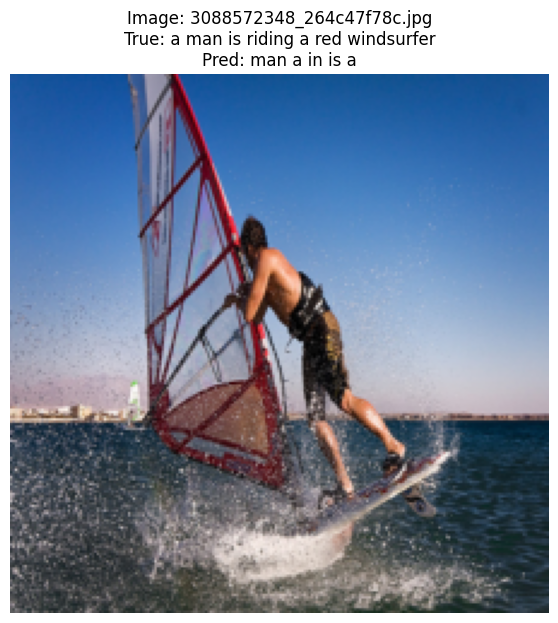

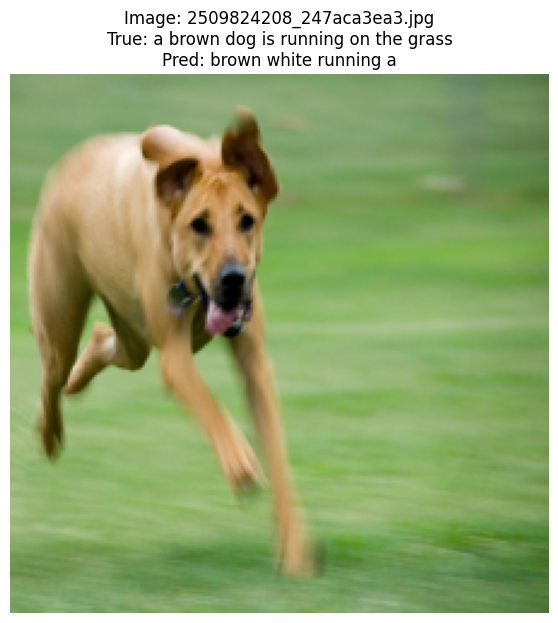

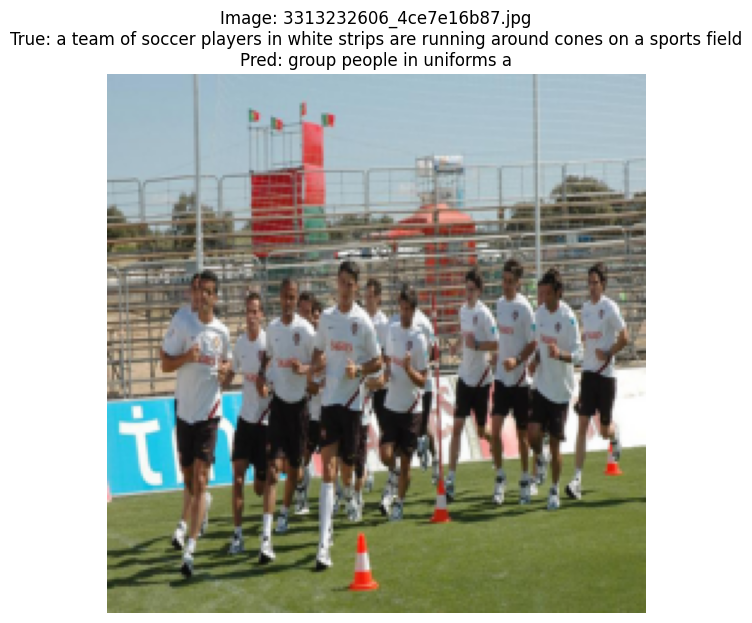

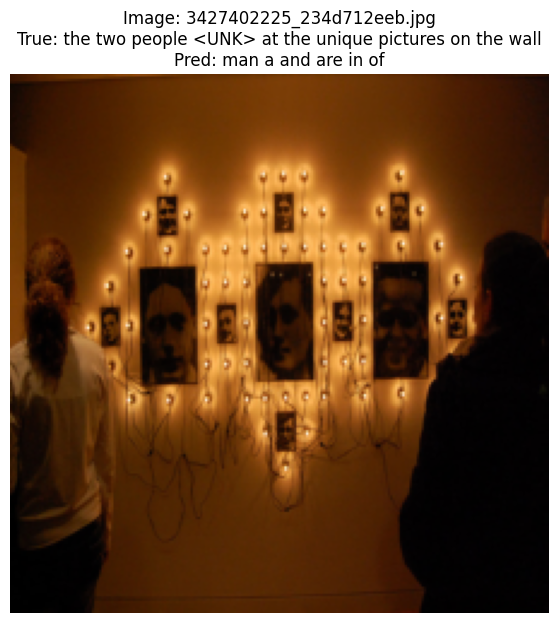

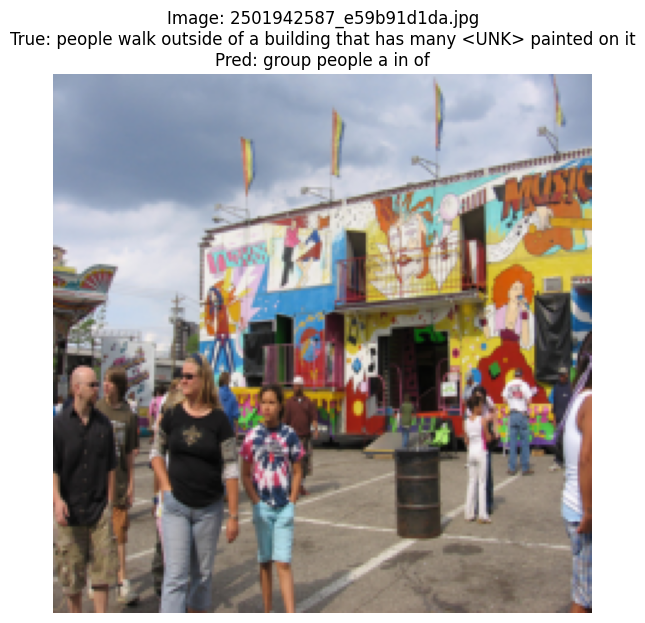

In [45]:
print(f"\n--- Loading best model from {MODEL_SAVE_PATH} for final use ---")

if os.path.exists(MODEL_SAVE_PATH):
    checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device)

    # Re-initialize vocabulary from saved state
    loaded_vocab = Vocabulary(checkpoint['vocab_freq_threshold'])
    loaded_vocab.stoi = checkpoint['vocab_stoi']
    loaded_vocab.itos = checkpoint['vocab_itos']
    # Important: Reset internal index counter if add_word might be called later (though unlikely for inference)
    loaded_vocab.idx = len(loaded_vocab.itos)

    # Re-initialize models with saved hyperparameters
    loaded_encoder = EncoderCNN(checkpoint['embed_size']).to(device)
    loaded_decoder = DecoderRNN(
        checkpoint['embed_size'],
        checkpoint['hidden_size'],
        len(loaded_vocab), # vocab_size from loaded_vocab
        checkpoint['num_layers_lstm']
    ).to(device)

    loaded_encoder.load_state_dict(checkpoint['encoder_state_dict'])
    loaded_decoder.load_state_dict(checkpoint['decoder_state_dict'])
    print(f"Best model from epoch {checkpoint.get('epoch', 'N/A')} with BLEU-4 {checkpoint.get('best_val_bleu4', 'N/A'):.4f} loaded successfully.")

    # --- Visualization with some samples (e.g., from validation set) ---
    print("\n--- Visualizing some samples with the best model ---")
    loaded_encoder.eval()
    loaded_decoder.eval()

    num_viz_samples = 5
    if len(val_dataset) >= num_viz_samples:
        # Get a few random samples from the validation dataset to visualize
        # val_dataset.dataset is the original Flickr8kDataset (after splitting)
        # val_dataset.indices are the indices into that original Flickr8kDataset

        sample_indices_in_subset = random.sample(range(len(val_dataset)), num_viz_samples)

        for i_subset in sample_indices_in_subset:
            img_tensor, true_caption_tensor = val_dataset[i_subset]

            # Get original image name for title
            # Accessing the 'df' of the val_dataset (which is a subset of the original captions_df_all)
            original_img_id = val_dataset.df.iloc[i_subset]["image"] # df in val_dataset is already the subset df

            # Get one of the true captions for display (optional)
            true_caption_text = " ".join([loaded_vocab.itos[idx.item()] for idx in true_caption_tensor
                                          if idx.item() not in {loaded_vocab.stoi["<SOS>"], loaded_vocab.stoi["<EOS>"], loaded_vocab.stoi["<PAD>"]}])


            generated_caption_viz = generate_caption_beam_search(
                img_tensor, loaded_encoder, loaded_decoder, loaded_vocab, device
            )

            img_display = unnormalize_image(img_tensor) # unnormalize expects tensor on correct device
            plt.figure(figsize=(7,7))
            plt.imshow(img_display)
            title_text = f"Image: {original_img_id}\n"
            title_text += f"True: {true_caption_text}\n"
            title_text += f"Pred: {' '.join(generated_caption_viz)}"
            plt.title(title_text)
            plt.axis('off')
            plt.show()
    else:
        print(f"Not enough samples in validation set for {num_viz_samples} visualizations (found {len(val_dataset)}).")

    # --- Final Quantitative Evaluation (Optional: on a dedicated test set) ---
    # If you had a separate final test_loader and test_image_id_to_references:
    # print("\n--- Final evaluation on a dedicated Test Set (if available) ---")
    # test_loss, test_bleu4 = evaluate_model(loaded_encoder, loaded_decoder, test_loader, criterion, loaded_vocab, device, test_image_id_to_references)
    # print(f"Final Test Set Performance -> Loss: {test_loss:.4f}, BLEU-4: {test_bleu4:.4f}")

else:
    print(f"Error: Model file not found at {MODEL_SAVE_PATH}. Cannot perform final visualization/evaluation.")
